<a href="https://colab.research.google.com/github/CristinaMarsh/100-Days-Of-ML-Code/blob/master/TStool/neuralforecas_learning_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 7.1 MB/s 
     |████████████████████████████████| 585 kB 61.0 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 419 kB 39.0 MB/s 
     |████████████████████████████████| 140 kB 43.0 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 55.3 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
     |████████████████████████████████| 144 kB 73.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 138 kB 68.8 MB/s 
     |████████████████████████████████| 2.3 MB 55.5 MB/s 
     |████████████████████████████████| 357 kB 73.2 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 

In [2]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
Y_df, X_df, _ = nf.data.datasets.long_horizon.LongHorizon.load('data', 'ILI')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
X_df['ds'] = pd.to_datetime(X_df['ds'])
Y_df.head()

100%|██████████| 314M/314M [00:08<00:00, 35.7MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:neuralforecast.data.datasets.utils:Decompressing zip file...
INFO:neuralforecast.data.datasets.utils:Successfully decompressed data/longhorizon/datasets/datasets.zip


,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


In [4]:
Y_df.unique_id.value_counts()

% WEIGHTED ILI       966
%UNWEIGHTED ILI      966
AGE 0-4              966
AGE 5-24             966
ILITOTAL             966
NUM. OF PROVIDERS    966
OT                   966
Name: unique_id, dtype: int64

In [5]:
Y_df.ds.value_counts()

2002-01-01    7
2013-07-30    7
2014-03-11    7
2014-03-18    7
2014-03-25    7
             ..
2008-04-01    7
2008-04-08    7
2008-04-15    7
2008-04-22    7
2020-06-30    7
Name: ds, Length: 966, dtype: int64

In [6]:
X_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4
0,% WEIGHTED ILI,2002-01-01,-0.5,-0.333333,-0.500000,-0.500000
1,% WEIGHTED ILI,2002-01-08,-0.5,-0.333333,-0.266667,-0.480822
2,% WEIGHTED ILI,2002-01-15,-0.5,-0.333333,-0.033333,-0.461644
3,% WEIGHTED ILI,2002-01-22,-0.5,-0.333333,0.200000,-0.442466
4,% WEIGHTED ILI,2002-01-29,-0.5,-0.333333,0.433333,-0.423288
...,...,...,...,...,...,...
6757,OT,2020-06-02,-0.5,-0.333333,-0.466667,-0.080822
6758,OT,2020-06-09,-0.5,-0.333333,-0.233333,-0.061644
6759,OT,2020-06-16,-0.5,-0.333333,0.000000,-0.042466
6760,OT,2020-06-23,-0.5,-0.333333,0.233333,-0.023288


In [7]:
X_df.unique_id.value_counts()

% WEIGHTED ILI       966
%UNWEIGHTED ILI      966
AGE 0-4              966
AGE 5-24             966
ILITOTAL             966
NUM. OF PROVIDERS    966
OT                   966
Name: unique_id, dtype: int64

## Split train/test sets

In [8]:
output_size = 24
Y_df_test = Y_df.groupby('unique_id').tail(output_size)
Y_df_train = Y_df.drop(Y_df_test.index)

X_df_train = X_df.drop(Y_df_test.index)

## Define WindowsDataset and TimeSeriesLoader

In [9]:
input_size = 5 * output_size

train_mask_df, val_mask_df, _ = nf.experiments.utils.get_mask_dfs(
    Y_df=Y_df_train,#Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_val=7 * output_size, #7? unique_id? 
    ds_in_test=0
)

In [13]:

train_mask_df

,unique_id,ds,sample_mask,available_mask
0,% WEIGHTED ILI,2002-01-01,1,1
1,% WEIGHTED ILI,2002-01-08,1,1
2,% WEIGHTED ILI,2002-01-15,1,1
3,% WEIGHTED ILI,2002-01-22,1,1
4,% WEIGHTED ILI,2002-01-29,1,1
...,...,...,...,...
6589,OT,2019-12-17,0,1
6590,OT,2019-12-24,0,1
6591,OT,2019-12-31,0,1
6592,OT,2020-01-07,0,1


In [14]:
val_mask_df

,unique_id,ds,sample_mask,available_mask
0,% WEIGHTED ILI,2002-01-01,0,1
1,% WEIGHTED ILI,2002-01-08,0,1
2,% WEIGHTED ILI,2002-01-15,0,1
3,% WEIGHTED ILI,2002-01-22,0,1
4,% WEIGHTED ILI,2002-01-29,0,1
...,...,...,...,...
6589,OT,2019-12-17,1,1
6590,OT,2019-12-24,1,1
6591,OT,2019-12-31,1,1
6592,OT,2020-01-07,1,1


In [11]:
plot_df = Y_df_train.merge(
    train_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_train'}),
    how='left',
    on=['unique_id', 'ds']
).merge(
    val_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_val'}),
    how='left',
    on=['unique_id', 'ds']
)

In [12]:
plot_df

,unique_id,ds,y,sample_mask_train,sample_mask_val
0,% WEIGHTED ILI,2002-01-01,-0.421499,1,0
1,% WEIGHTED ILI,2002-01-08,-0.331239,1,0
2,% WEIGHTED ILI,2002-01-15,-0.342763,1,0
3,% WEIGHTED ILI,2002-01-22,-0.199782,1,0
4,% WEIGHTED ILI,2002-01-29,-0.218426,1,0
...,...,...,...,...,...
6589,OT,2019-12-17,3.783136,0,1
6590,OT,2019-12-24,3.948533,0,1
6591,OT,2019-12-31,4.571083,0,1
6592,OT,2020-01-07,4.902510,0,1


In [15]:
plot_df['y_train'] = np.where(plot_df['sample_mask_train'] == 1, plot_df['y'], np.nan)
plot_df['y_val'] = np.where(plot_df['sample_mask_val'] == 1, plot_df['y'], np.nan)

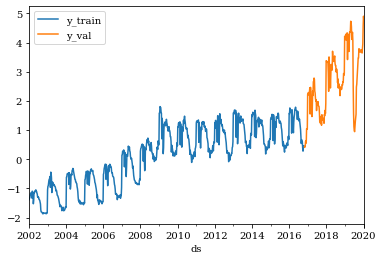

In [16]:
plot_df.query('unique_id == "OT"').set_index('ds')[['y_train', 'y_val']].plot()

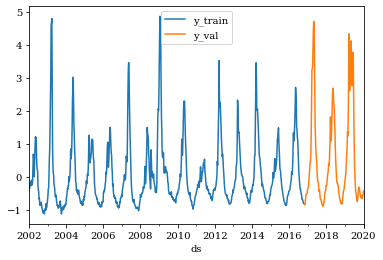

In [17]:
plot_df.query('unique_id == "% WEIGHTED ILI"').set_index('ds')[['y_train', 'y_val']].plot()

In [18]:
train_dataset = nf.data.tsdataset.WindowsDataset(
    Y_df=Y_df_train, 
    X_df=X_df_train,
    f_cols=[f'ex_{i}' for i in range(1, 5)],
    input_size=input_size,
    output_size=output_size,
    mask_df=train_mask_df
)

In [21]:
input_size

120

In [19]:
val_dataset = nf.data.tsdataset.WindowsDataset(
    Y_df=Y_df_train, 
    X_df=X_df_train,
    f_cols=[f'ex_{i}' for i in range(1, 5)],
    input_size=input_size,
    output_size=output_size,
    mask_df=val_mask_df
)

In [22]:
train_loader = nf.data.tsloader.TimeSeriesLoader(
    train_dataset, batch_size=32, 
    n_windows=256,
    shuffle=True
)

In [23]:
val_loader = nf.data.tsloader.TimeSeriesLoader(
    val_dataset, 
    batch_size=1
)

In [25]:
model = nf.models.nbeats.nbeats.NBEATS(
    n_time_in=input_size, n_time_out=output_size,
    n_x=4, n_x_hidden=[4],
    frequency='W-TUE'
)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpstvnwugw
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpstvnwugw/_remote_module_non_sriptable.py


In [26]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss")

trainer = pl.Trainer(max_epochs=20,
                     gpus=-1 if t.cuda.is_available() else 0,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | _NBEATS | 2.1 M 
----------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.321     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [27]:
Y_df_forecast = model.forecast(Y_df_train, X_df=X_df)
Y_df_forecast.rename(columns={'y': 'y_hat'}, inplace=True)
Y_df_forecast.head()

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
%UNWEIGHTED ILI   0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
AGE 0-4           0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
AGE 5-24          0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
ILITOTAL          0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
NUM. OF PROVIDERS 0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
OT                0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
INFO:root:
Total data 			6762 time stamps 
Available percentage=100.0, 

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,y_hat
0,% WEIGHTED ILI,2020-01-21,-0.483298
1,% WEIGHTED ILI,2020-01-28,-0.228479
2,% WEIGHTED ILI,2020-02-04,-0.438339
3,% WEIGHTED ILI,2020-02-11,-0.309105
4,% WEIGHTED ILI,2020-02-18,-0.116488


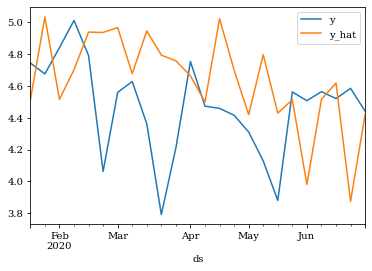

In [28]:
Y_df_plot = Y_df_test.merge(Y_df_forecast, how='left', on=['unique_id', 'ds'])
Y_df_plot.query('unique_id == "OT"').set_index('ds').plot()